## Structure prediction of copper phosphides

### Abstract

Transition-metal phosphides represent a class of materials with uses throughout the renewable energy field especially in the areas of hydrogen evolution reactions and as Li-ion battery conversion anodes.  In the case of Li-ion batteries, the transition metal copper is especially of interest as it is the current collector for most modern Li ion batteries, and Cu$_3$P is a well studied conversion anode in both Li and Na-ion batteries. Thus, through a two-step structure prediction method, stable structures at high temperature and pressure have been identified and characterised by density-functional theory (DFT) calculations.  This study highlights a novel $F$m$\bar{3}$m phase of Cu$_2$P, which has a higher gravimetric capacity of 508 mAh/g, compared to the known conversion anode Cu$_3$P which has experimentally shown capacities up to 415 mAh/g. Additionally, DFT geometry optimisations predict the $I$4/mmm phase of Cu$_2$P to be stable up to 50 GPa, and thermodynamic predictions from the DFT zero-point energy predict $F$m$\bar{3}$m Cu$_2$P to be stable at temperatures up to 430 K. Furthermore, crystal structure prediction at elevated pressures up to 10 GPa shows that the copper-rich phases which contain 6 and 9-fold coordinated phosphorus become more stable at elevated pressures, a trend confirmed in other transition-metal phosphide phases.  These first-principles predictions of the stable Cu$_2$P phase as well as other meta-stable high-pressure phases highlight the need to further explore this phase diagram experimentally, in order to determine which phases are synthesizable, and represents the first direct prediction of a new high-capacity Li-ion battery conversion anode which is more energetically stable than Cu$_3$P.  

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tqdm
import glob
import pickle
from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.hull import EnsembleHull
from matador.scrapers import castep2dict, res2dict
from matador.utils.cursor_utils import filter_unique_structures
from matador.utils.cell_utils import standardize_doc_cell, get_spacegroup_spg
from matador.plotting import set_style
set_style()
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

### Results

In [2]:
# load AIRSS structures obtained from searching
cursor, failures = res2dict('/u/fs1/afh41/hull-CuP-afh41-CuP/*.res', db=True)
if failures:
    print(failures)

In [3]:
# do some pruning: reevaluate symmetries and reduce cells
cursor = [standardize_doc_cell(doc, ) for doc in cursor]
for doc in cursor:
    doc['space_group'] = get_spacegroup_spg(doc, symprec=0.1)

In [4]:
# filter them for uniqueness
filtering = False
if filtering:
    cursor = filter_unique_structures(cursor)

In [5]:
hull = QueryConvexHull(cursor=cursor, species='CuP', no_plot=True, uniq=False, source=True)

6 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0                  0.03       11.3          0.0    Fm-3m          Cu          1      ICSD  
           └────────────────── /u/fs1/afh41/hull-CuP-afh41-CuP/Cu-OQMD_592441-CollCode43493_0.res
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* CuP-aw2v56-a_final                              0.04       19.8          0.0    Fm-3m         Cu2P         2     AIRSS  
   

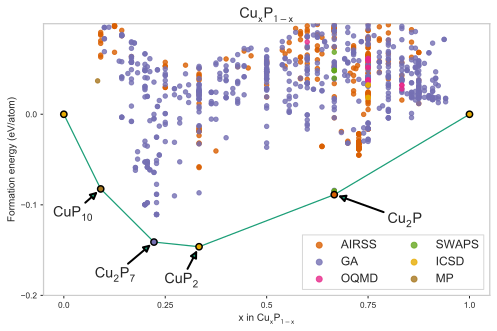

In [6]:
from matador.plotting import plot_2d_hull
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax = plot_2d_hull(
    hull,
    ax=ax,
    label_cutoff=8e-3, 
    colour_by_source=True,
    plot_hull_points=False,
    show=False,
    alpha=0.8, 
    label_offset=(1.15, 0.02),
    eform_limits=(-0.2, 0.1),
    sources=['ICSD', 'MP', 'SWAPS', 'OQMD', 'GA', 'AIRSS']
)
ax.set_yticks([-0.2, -0.1, 0])
plt.show()
# plt.savefig('CuP-convex-hull.png',bbox_inches='tight',transparent=True)

In [7]:
cursor, failures = res2dict('/u/fs1/afh41/voltage-LiCuP-afh41-LiCuP-noCu2P/*.res', db=True)

if failures:
    print(failures)

In [25]:
# This is the ternary hull used to create the voltage profiles. It has ommitted the disputed Cu-Li
# phases and the high P content Cu-P phases to identify specifically the Cu3P and Cu2P voltage profiles

hull = QueryConvexHull(cursor=cursor,
        #expt='Cu3P-deetrizio-exp.csv',
        #expt='Cu3P-expt-voltage-bichat2004electrochemical.csv',
        expt='/u/fs1/afh41/voltage-LiCuP-afh41-LiCuP-noCu2P/Cu3P-expt-voltage-bichat2004electrochemicalC8.csv',
        no_plot=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

13 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0                  0.07       11.3          0.0    Fm-3m          Cu          1      ICSD  
* CuP-aw2v56-a_final                              0.04       39.5          0.0    Imm2          Cu2P         2     AIRSS  
* Cu2LiP2-OQMD_2275-CollCode2734                  0.01       69.5          0.0   I4/mmm        Cu2LiP2       1      ICSD  
* Cu4Li5P6-OQMD_33279-CollCode2735                0.05      206.9          0.0    Immm        Cu4Li5P

In [28]:
from matador.utils.chem_utils import get_formula_from_stoich

In [29]:
# remove Cu2P from the plot and calculate the convex hull without Cu2P
noCu2Pcursor = []
for item in cursor:
    if get_formula_from_stoich(item['stoichiometry']) != 'Cu2P':
        noCu2Pcursor.append(item)
        
hullnoCu2P = QueryConvexHull(cursor=noCu2Pcursor,
        no_plot=True,
        quiet=True,
        subcmd='voltage', elements=['Li', 'Cu', 'P'])

Something fishy with height above plane, returning 0...
0.0 0.0 0.0
[ 0.01140906  0.         -0.        ]
Something fishy with height above plane, returning 0...
0.0 0.75 -0.011409062500142397
[ 0.01140906  0.         -0.        ]
13 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0                  0.07       11.3          0.0    Fm-3m          Cu          1      ICSD  
* CuP-GA-m0ol1y-9x19                              0.01       50.8          0.0     P1           Cu3P         2      

In [60]:
from matador.plotting import plot_voltage_curve
from matador.plotting.battery_plotting import add_voltage_curve

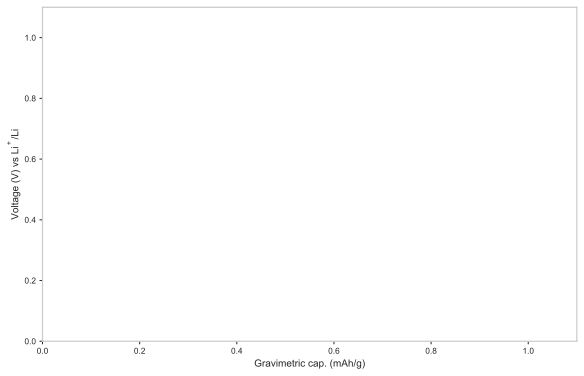

In [66]:
# need to get ternary hull data to make the voltage curves
# possibly use 'add_voltage_curve' instead directly to make this less cumbersome
fig, ax = plt.subplots(figsize=(8, 5))

add_voltage_curve(hull.voltage_data['Q'],
                  hull.voltage_data['voltages'],
                  ax_volt=ax,
                  label=r'Cu$_2$P',
                  c='darkblue')
add_voltage_curve(hullnoCu2P.voltage_data['Q'],
                  hullnoCu2P.voltage_data['voltages'],
                  ax_volt=ax,
                  label=r'Cu$_2$P',
                  c='lightblue')

ax.set_ylabel('Voltage (V) vs Li$^+/$Li')
ax.set_xlabel('Gravimetric cap. (mAh/g)')

_, end = ax.get_ylim()
from matplotlib.ticker import MultipleLocator
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.set_ylim(0, 1.1 * end)
_, end = ax.get_xlim()
ax.set_xlim(0, 1.1 * end)
ax.grid(False)
plt.tight_layout(pad=0.0, h_pad=1.0, w_pad=0.2)

plt.show()

In [13]:
# will need to redo these with your VESTA colour scheme
from matador.plotting import plot_spectral

Reordering bands based on local gradients...
Loading settings from /u/fs1/afh41/.matadorrc
Displaying plot...


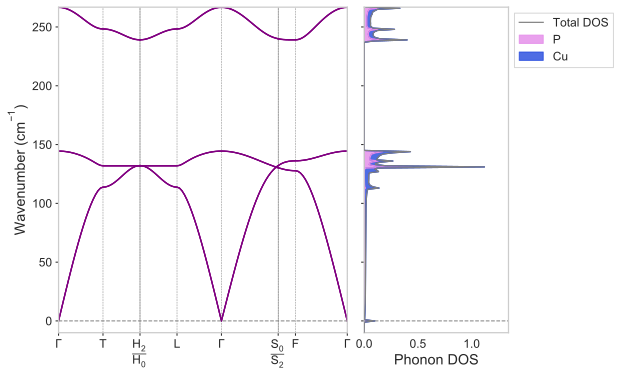

In [14]:
ax = plot_spectral(
    '/u/fs1/afh41/Cu2P-phonon-correct-path/CuP-Ir2P-OQMD_30622-CollCode640898', 
    phonons=True,
    band_colour='purple', 
  #  png=True
)

Loading settings from /u/fs1/afh41/.matadorrc
Loading settings from /u/fs1/afh41/.matadorrc
Displaying plot...


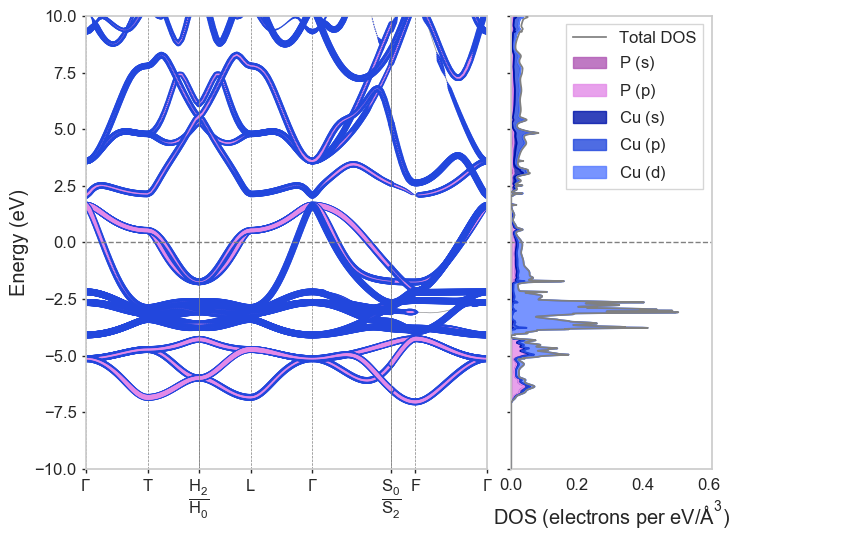

In [15]:
# write now displaying as svg is too taxing when there are many thousand points, so switch to png here 
# long-term solution is probably to rewrite pdis plotting to use variable line widths with variable zorder...
set_matplotlib_formats('png')
plot_spectral(
    '/u/fs1/afh41/Cu2P-bands-elec/CuP-Ir2P-OQMD_30622-CollCode640898',
    pdis_interpolation_factor=5,
  #  png=True
)
set_matplotlib_formats('svg')

Reordering bands based on local gradients...
Displaying plot...


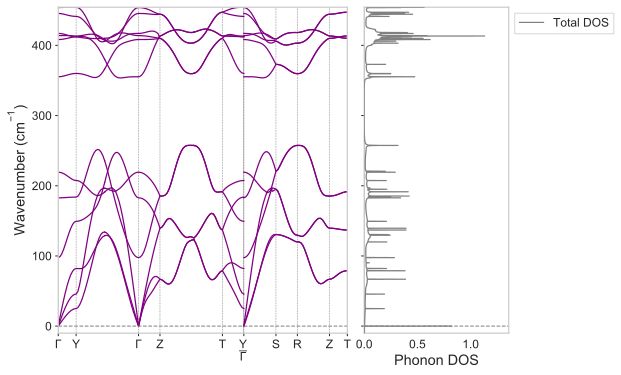

In [16]:
# need to get read permission on the cell file to plot this properly
plot_spectral(
    '/u/fs1/afh41/P-phonon/P-CollCode150873_prim-out_prim',
    phonons=True,
    band_colour='purple', 
   # png=True,
)